Using TensorFlow backend.


     index    fname                           label real_int  \
0        0  000.jpg  [1, 0, 0, 0, 0, 1, 0, 0, 0, 0]     0, 5   
1        1  001.jpg  [0, 0, 1, 0, 0, 0, 0, 0, 0, 1]     2, 9   
2        2  002.jpg  [1, 0, 1, 0, 0, 0, 0, 0, 0, 0]     0, 2   
3        3  003.jpg  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]     0, 0   
4        4  004.jpg  [0, 0, 0, 1, 0, 1, 0, 0, 0, 0]     3, 5   
5        5  005.jpg  [0, 0, 0, 1, 0, 0, 0, 1, 0, 0]     7, 3   
6        6  006.jpg  [0, 0, 1, 0, 0, 0, 0, 0, 0, 1]     9, 2   
7        7  007.jpg  [1, 0, 1, 0, 0, 0, 0, 0, 0, 0]     2, 0   
8        8  008.jpg  [0, 0, 1, 0, 0, 0, 0, 0, 0, 1]     2, 9   
9        9  009.jpg  [0, 0, 0, 0, 0, 1, 0, 0, 0, 1]     9, 5   
10      10  010.jpg  [0, 0, 1, 1, 0, 0, 0, 0, 0, 0]     2, 3   
11      11  011.jpg  [0, 0, 1, 0, 0, 0, 0, 1, 0, 0]     2, 7   
12      12  012.jpg  [0, 0, 1, 0, 0, 1, 0, 0, 0, 0]     2, 5   
13      13  013.jpg  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]     2, 2   
14      14  014.jpg  [1, 0, 0, 0, 0, 0, 

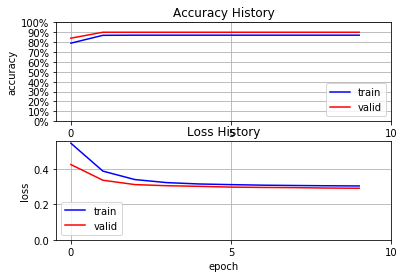

In [1]:
from __future__ import print_function

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

from keras.models import Sequential

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dense

from keras.utils import plot_model
from keras.utils import np_utils

from keras.callbacks import EarlyStopping

################################################################################
# Read the data
################################################################################
raw_data = pd.read_csv('D://ProjectFashion//DATASET//labels.csv')

print(raw_data)

print(" >>> ", len(raw_data))

raw_pic = []
raw_lbl = []

for i in range(0, len(raw_data)):
#for i in range(0, len(raw_data) - 1):
    item = raw_data.iloc[i]
    
    img_file = 'D://ProjectFashion//DATASET//train//' + item['fname']
    print(img_file)
    img = cv2.imread(img_file)

    y = 0
    h = 160
    x = int((646 - 640) / 2)
    w = 640 
    
    crop_img = img[y:y+h, x:x+w]
    crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
    raw_pic.append(crop_img)
    
    lbl = item['label']
    print(lbl)
    lbl_in_np = np.fromstring(lbl[1:-1], dtype=int, sep=',')
    print(lbl_in_np)
    
    raw_lbl.append(lbl_in_np)
    
#--- process image -------------------------------------------------------------
train_img = np.array(raw_pic)
# print(" >>> train_img.shape = ", train_img.shape)
train_img_size_h = train_img.shape[1]
train_img_size_w = train_img.shape[2]
# print(" >>> h = ", train_img_size_h)
# print(" >>> w = ", train_img_size_w)

# train_img = train_img.astype('float32') 
train_img = train_img / 255.0

#--- preprocess label ----------------------------------------------------------
train_lbl = np.array(raw_lbl)
# print(" >>> train_ans.shape = ", train_lbl.shape)

################################################################################
# Build the model
################################################################################
input_shape_img = (train_img.shape[1], train_img.shape[2], 3)
batch_size = 32
num_epochs = 10 # WAS 100
num_classes = 10
conv_size = 32

# print(" >>> input_shape_img = ", input_shape_img)

#-------------------------------------------------------------------------------
model = Sequential()

model.add(Conv2D(conv_size, (3, 3), activation='relu', padding='same', input_shape=input_shape_img)) 
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(conv_size, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(conv_size, (3, 3), activation='relu', padding='same')) 
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(conv_size, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(num_classes, activation='sigmoid'))

#-------------------------------------------------------------------------------
model.compile(loss='binary_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])
              
model.summary()

################################################################################
# Train the model
################################################################################
print(" >>> CNN Model Training ... \n")

early_stop = EarlyStopping(monitor='loss', patience=50, verbose=1)
                                            
history = model.fit(train_img, train_lbl,
                        batch_size=batch_size,
                        epochs=num_epochs,
                        verbose=1,
                        validation_split=0.1,
                        callbacks=[early_stop])

################################################################################
# Check the history
################################################################################
plt.figure(facecolor='white')

# accuracy ---------------------------------------------------------------------
ax1 = plt.subplot(2,1,1)

plt.plot([x * 100 for x in history.history['accuracy']], label="accuracy", color="blue")
plt.plot([x * 100 for x in history.history['val_accuracy']], label="val_accuracy", color="red")

plt.title('Accuracy History')
plt.ylabel('accuracy')
# plt.xlabel('epoch')

plt.legend(['train', 'valid'], loc='lower right')

plt.ylim(0, 1)
plt.xticks(np.arange(0, num_epochs + 1, 5))
plt.yticks(np.arange(0, 100.1, 10))
ax1.yaxis.set_major_formatter(plt.FuncFormatter('{:.0f}%'.format))
plt.grid()

# loss -------------------------------------------------------------------------
plt.subplot(2,1,2)

plt.plot(history.history['loss'], label="loss", color="blue")
plt.plot(history.history['val_loss'], label="val_loss", color="red")

plt.title('Loss History')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'valid'], loc='lower left')

plt.ylim(0)
plt.xticks(np.arange(0, num_epochs + 1, 5))
plt.grid()
plt.show()



In [12]:
################################################################################
# Check the test dataset
################################################################################
t_data = pd.read_csv('D://ProjectFashion//DATASET//test_labels.csv')

# print(raw_data)

# print(" >>> ", len(raw_data))

t_pic = []
t_lbl = []
t_int = []
t_str = []

for i in range(0, len(t_data)):
    item = t_data.iloc[i]
    
    img_file = 'D://ProjectFashion//DATASET//test//' + item['fname']
#     print(img_file)
    img = cv2.imread(img_file)
    
    y = 0
    h = 160
    x = int((646 - 640) / 2)
    w = 640 
    
    crop_img = img[y:y+h, x:x+w]
    crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
    t_pic.append(crop_img)
    
    lbl = item['label']
#     print(lbl)
    lbl_in_np = np.fromstring(lbl[1:-1], dtype=int, sep=',')
#     print(lbl_in_np)
    
    t_lbl.append(lbl_in_np)
    
    t_int.append(item['real_int'])
    t_str.append(item['real_str'])
    
#--- process image -------------------------------------------------------------
test_img = np.array(t_pic)
# print(" >>> test_img.shape = ", test_img.shape)

# test_img = test_img.astype('float32') 
test_img = test_img / 255.0

#--- preprocess label ----------------------------------------------------------
test_lbl = np.array(t_lbl)
# print(" >>> test_lbl.shape = ", test_lbl.shape)

#--- evaluate ------------------------------------------------------------------
acc = model.evaluate(test_img, test_lbl, verbose=1)[1]
print(" >>> Accuracy on test data = ", round(acc, 3))

9/9 [==============================] - 2s 215ms/step
 >>> Accuracy on test data =  0.867
